In [7]:
import os
import numpy as np
import pandas as pd

from astropy import units as u
from astropy.table import Table, Column, MaskedColumn
from astropy.time import Time, TimeDelta
from astropy.coordinates import SkyCoord, Distance, GCRS, CartesianRepresentation, match_coordinates_sky
from astropy.wcs import WCS
from astropy.io import fits, ascii
from astroquery.vizier import Vizier
import itertools

from collections import Counter
import matplotlib.pyplot as plt

import pickle

### 函数定义

In [100]:
def work_sext(
    image_path: str,
    config_path: str,
    out_path: str,
    flag_path: str,
    weight_path: str,
    out_para_path: str,
    filter_path: str,
):
    """
    Do astrometry by source-extractor.

    Do astrometry by source-extractor, the basic use of source-extractor is 'source-extractor  -c ' + fp_config + fp_image'

    Parameters
    ----------
    image_path : str
        The image fits to be processed, *.fits.
    config_path : str
        The config file of source-extractor, *.sex.
    out_path : str
        The name of the output catalog.
    out_para_path : str
        The parameters of the output catalog, *.param.
    filter_path : str
        The filter of the image, *.conv.

    Returns
    -------
    None

    Examples
    -------
    >>> work_sext(fp_img,fp_config_sext,fp_out_sext,fp_para_sext,fp_filter_sext)
    """
    fp_image = image_path
    fp_config = config_path
    fp_out = out_path
    fp_flg = flag_path
    fp_wht = weight_path
    fp_para = out_para_path
    fp_filter = filter_path

    cmd_sex = (
        "sex -c "
        + fp_config + " "
        + fp_image
        + " -CATALOG_NAME "
        + fp_out
        + " -FLAG_IMAGE "
        + fp_flg
        + " -WEIGHT_IMAGE "
        + fp_wht
        + " -PARAMETERS_NAME "
        + fp_para
        + " -FILTER_NAME "
        + fp_filter
    )

    os.system(cmd_sex)

def gaiadr3_query(
    ra: list,
    dec: list,
    rad: float = 1.0,
    maxmag: float = 25,
    maxsources: float = 1000000,
):
    """
    Acquire the Gaia DR3.

    This function uses astroquery.vizier to query Gaia DR3 catalog.

    Parameters
    ----------
    ra : list
        RA of center in degrees.
    dec : list
        Dec of center in degrees.
    rad : float
        Field radius in degrees.
    maxmag : float
        Upper limit magnitude.
    maxsources : float
        Maximum number of sources.

    Returns
    -------
    Table
        table of reference catalog.

    Examples
    --------
    >>> catalog = gaiadr3_query(ra, dec, rad, maxmag, maxsources)
    """

    vquery = Vizier(
        columns=["RA_ICRS", "DE_ICRS", "pmRA", "pmDE", "Plx", "RVDR2", "Gmag", "RV"],
        row_limit=maxsources,
        column_filters={"Gmag": ("<%f" % maxmag), "Plx": ">0"},
    )
    coord = SkyCoord(ra=ra, dec=dec, unit=u.deg, frame="icrs")
    r = vquery.query_region(coord, radius=rad * u.deg, catalog="I/355/gaiadr3")

    return r[0]

def ideal_cel_coord(xi, eta, ra_c, dec_c):
    ra_c = np.deg2rad(ra_c)
    dec_c = np.deg2rad(dec_c)

    ra = np.arctan(xi / (np.cos(dec_c) - eta * np.sin(dec_c))) + ra_c
    dec = np.arctan(
        (eta * np.cos(dec_c) + np.sin(dec_c))
        / (np.cos(dec_c) - eta * np.sin(dec_c))
        * np.cos(ra - ra_c)
    )
    ra = np.degrees(ra)
    dec = np.degrees(dec)

    return ra, dec

def cel_ideal_coord(ra, dec, ra_c, dec_c):

    ra = np.radians(ra)
    dec = np.radians(dec)
    ra_c = np.radians(ra_c)
    dec_c = np.radians(dec_c)

    xi = (np.cos(dec) * np.sin(ra - ra_c)) / (
        np.sin(dec_c) * np.sin(dec) + np.cos(dec_c) * np.cos(dec) * np.cos(ra - ra_c)
    )
    eta = (
        np.cos(dec_c) * np.sin(dec) - np.sin(dec_c) * np.cos(dec) * np.cos(ra - ra_c)
    ) / (np.sin(dec_c) * np.sin(dec) + np.cos(dec_c) * np.cos(dec) * np.cos(ra - ra_c))

    return xi, eta

def pos_side(ra_a, dec_a, ra_b, dec_b):
    ra_a_c = np.deg2rad(ra_a)
    dec_a_c = np.deg2rad(dec_a)
    ra_b_c = np.deg2rad(ra_b)
    dec_b_c = np.deg2rad(dec_b)

    a_vector = np.array([np.cos(dec_a_c) * np.cos(ra_a_c), np.cos(dec_a_c) * np.sin(ra_a_c), np.sin(dec_a_c)])
    b_vector = np.array([np.cos(dec_b_c) * np.cos(ra_b_c), np.cos(dec_b_c) * np.sin(ra_b_c), np.sin(dec_b_c)])
    return np.rad2deg(np.arccos(np.sum(a_vector * b_vector, axis=0)))


def cal_plate_model(X_x, X_y, Y_xi, Y_eta, cof):
    
    X_xy = []
    for i in range(0, cof + 1):
        for j in range(0, i + 1):
            X_xy.append(X_x ** (i - j) * X_y ** j)
    X_xy = np.array(X_xy).T
    
    A_CD1 = np.linalg.inv(X_xy.T @ X_xy) @ X_xy.T @ Y_xi
    A_CD2 = np.linalg.inv(X_xy.T @ X_xy) @ X_xy.T @ Y_eta

    A_CD = np.array([A_CD1, A_CD2])

    return A_CD

def use_plate_model(X_x, X_y, A_CD, cof):

    X_xy = []
    for i in range(0, cof + 1):
        for j in range(0, i + 1):
            X_xy.append(X_x ** (i - j) * X_y ** j)
    X_xy = np.array(X_xy).T

    # xi_eta = A_CD @ X_xy.T * (np.pi / 180)
    xi_eta = A_CD @ X_xy.T

    return xi_eta

def cal_plate_model_mag(X_x, X_y, mag, Y_xi, Y_eta, cof, cof_mag):
    
    X_xy = []
    for i in range(0, cof + 1):
        for j in range(0, i + 1):
            X_xy.append(X_x ** (i - j) * X_y ** j)
    for k in range(1, cof_mag + 1):
        X_xy.append(mag ** k)
    # X_xy.append(mag * X_x)
    # X_xy.append(mag * X_y)
    # X_xy.append(mag * X_x ** 2)
    # X_xy.append(mag * X_x * X_y)
    # X_xy.append(mag * X_y ** 2)

    # X_xy.append(mag * X_x, mag * X_y, mag * X_x ** 2, mag * X_x * X_y, mag * X_y ** 2)

    X_xy = np.array(X_xy).T
    
    A_CD1 = np.linalg.inv(X_xy.T @ X_xy) @ X_xy.T @ Y_xi
    A_CD2 = np.linalg.inv(X_xy.T @ X_xy) @ X_xy.T @ Y_eta

    A_CD = np.array([A_CD1, A_CD2])

    return A_CD

def use_plate_model_mag(X_x, X_y, mag, A_CD, cof, cof_mag):

    X_xy = []
    for i in range(0, cof + 1):
        for j in range(0, i + 1):
            X_xy.append(X_x ** (i - j) * X_y ** j)
    for k in range(1, cof_mag + 1):
        X_xy.append(mag ** k)
    # X_xy.append(mag * X_x)
    # X_xy.append(mag * X_y)
    # X_xy.append(mag * X_x ** 2)
    # X_xy.append(mag * X_x * X_y)
    # X_xy.append(mag * X_y ** 2)
    # X_xy.append(mag * X_x, mag * X_y, mag * X_x ** 2, mag * X_x * X_y, mag * X_y ** 2)

    X_xy = np.array(X_xy).T

    xi_eta = A_CD @ X_xy.T * (np.pi / 180)
    xi_eta = A_CD @ X_xy.T

    return xi_eta

# def cal_plate_model(X_x, X_y, Y_xi, Y_eta):
#     # X_xy = np.array([np.ones_like(X_x), X_x, X_y, X_x ** 2, X_x * X_y, X_y ** 2, 
#     #              X_x ** 3, X_x ** 2 * X_y, X_x * X_y ** 2, X_y ** 3]).T
#     # X_xy = np.array([np.ones_like(X_x), X_x, X_y, X_x ** 2, X_x * X_y, X_y ** 2]).T
#     X_xy = np.array([np.ones_like(X_x), X_x, X_y, X_x ** 2, X_x * X_y, X_y ** 2]).T
    
#     A_CD1 = np.linalg.inv(X_xy.T @ X_xy) @ X_xy.T @ Y_xi

#     A_CD2 = np.linalg.inv(X_xy.T @ X_xy) @ X_xy.T @ Y_eta

#     A_CD = np.array([A_CD1, A_CD2])

#     return A_CD

# def use_plate_model(X_x, X_y, A_CD):
#     # X_xy = np.array([np.ones_like(X_x), X_x, X_y, X_x ** 2, X_x * X_y, X_y ** 2, 
#     #              X_x ** 3, X_x ** 2 * X_y, X_x * X_y ** 2, X_y ** 3]).T
#     X_xy = np.array([np.ones_like(X_x), X_x, X_y, X_x ** 2, X_x * X_y, X_y ** 2]).T
#     xi_eta = A_CD @ X_xy.T * (np.pi / 180)

#     return xi_eta

def write_ds9_region(filename, data, str_x, str_y):

    with open(filename, "w") as f:
        f.write(
            'global color=red dashlist=8 3 width=1 font="helvetica 10 normal roman" '
            "select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1"
            + "\n"
        )
        f.write("physical" + "\n")
        for i in range(len(data)):
            f.write(
                "circle("
                + str("%12.6f" % (data[str_x][i]))
                + ",  "
                + str("%12.6f" % (9232 - data[str_y][i]))
                + ","
                + str(15)
                + ")"
                + "\n"
            )

def match_box_id(points_x, points_y, bins_x, bins_y):
    # bins_x_id and bins_y_id
    bins_x_id = np.digitize(points_x, bins_x) - 1
    bins_y_id = np.digitize(points_y, bins_y) - 1

    return bins_x_id, bins_y_id


def cal_distort_model(dis_res_xy_list, bins_x, bins_y, bins_num, distort_sum_bins, distort_sum_values_x, distort_sum_values_y):

    for points_inf in dis_res_xy_list:
        points_x = points_inf[0, :]
        points_y = points_inf[1, :]
        distort_value_x = points_inf[2, :]
        distort_value_y = points_inf[3, :]

        bins_x_id, bins_y_id = match_box_id(points_x, points_y, bins_x, bins_y)

        distort_bins, _, _ = np.histogram2d(bins_x_id, bins_y_id, bins=(range(bins_num + 1), range(bins_num + 1)))
        distort_values_x, _, _ = np.histogram2d(bins_x_id, bins_y_id, bins=(range(bins_num + 1), range(bins_num + 1)),
                                                weights=distort_value_x)
        distort_values_y, _, _ = np.histogram2d(bins_x_id, bins_y_id, bins=(range(bins_num + 1), range(bins_num + 1)),
                                                weights=distort_value_y)

        distort_sum_bins += distort_bins
        distort_sum_values_x += distort_values_x
        distort_sum_values_y += distort_values_y

    return distort_sum_bins, distort_sum_values_x, distort_sum_values_y

def sigma_filter(data, data_rel, sigma_scale):

    mean_data = np.mean(data)
    std_data = np.std(data)
    # 小于μ-3σ或大于μ+3σ的数据均为异常值
    filter = (mean_data - sigma_scale * std_data < data) & (mean_data + sigma_scale * std_data > data)

    data_filter = data[filter]
    data_rel_filter = data_rel[filter]

    return data_filter, data_rel_filter

def sigma_filter_2(data1, data2, data_rel, sigma_scale):

    mean_data1 = np.mean(data1)
    std_data1 = np.std(data1)

    mean_data2 = np.mean(data2)
    std_data2 = np.std(data2)
    # 小于μ-3σ或大于μ+3σ的数据均为异常值
    filter1 = (mean_data1 - sigma_scale * std_data1 < data1) & (mean_data1 + sigma_scale * std_data1 > data1)
    filter2 = (mean_data2 - sigma_scale * std_data2 < data2) & (mean_data2 + sigma_scale * std_data2 > data2)

    filter = filter1 & filter2

    data1_filter = data1[filter]
    data2_filter = data2[filter]
    data_rel_filter = data_rel[filter]

    return data1_filter, data2_filter, data_rel_filter, filter

### 文件路径

In [9]:
CONFIG_PATH = "/home/fangwf/software/miniconda3/envs/csst_mci/lib/python3.11/site-packages/csst_mci_astrometry/data/"

band = "C2"
band_short = "r"
day = "230614"
obs_index = "08"
unkonw_index = "01"

obs_info = {"01": "20230614054340_20230614054840", "02" :"20240119021141_20240119021641", "03": "20240119021742_20240119022242", "04": "20240119022342_20240119022842", "05": "20240119022941_20240119023441"}

img_path: str = f'/home/fangwf/MCI_SimData/{day}/L1/ins/CSST_MCI_{band}_STAR_{obs_info[unkonw_index]}_202000000{unkonw_index}_{obs_index}_L0_VER.fits'


In [11]:
hdu_img = fits.open(img_path)
hdu_img_header = hdu_img[1].header
pointing_ra, pointing_dec = hdu_img_header["CRVAL1"], hdu_img_header["CRVAL2"]
CD1_1, CD1_2, CD2_1, CD2_2 = hdu_img_header["CD1_1"], hdu_img_header["CD1_2"], hdu_img_header["CD2_1"], hdu_img_header["CD2_2"]
x_ref, y_ref = hdu_img_header["CRPIX1"], hdu_img_header["CRPIX2"]

In [12]:
print(f"reference point pixel, {x_ref}, {y_ref}")
print(f"reference point celestical, {pointing_ra}, {pointing_dec}")

reference point pixel, 4607.5, 4615.5
reference point celestical, 260.0445206737792, -0.01074148799459571


### source-extractor结果

In [13]:
fp_out_sext = f"/home/fangwf/code/csst_mci_multiband_0614/sext_out/{band}_{band_short}_600_out.fits"
hdu_list =  fits.open(fp_out_sext)
hdu_list.info()
sext_out_filter = Table(hdu_list[2].data)

Filename: /home/fangwf/code/csst_mci_multiband_0614/sext_out/C2_r_600_out.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  LDAC_IMHEAD    1 BinTableHDU     12   1R x 1C   [12000A]   
  2  LDAC_OBJECTS    1 BinTableHDU    163   2889R x 39C   [1E, 1E, 1D, 1D, 1J, 1J, 1J, 1J, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1J, 1E, 1I, 1E]   


In [14]:
sext_out_filter

X_IMAGE,Y_IMAGE,XWIN_IMAGE,YWIN_IMAGE,XMIN_IMAGE,XMAX_IMAGE,YMAX_IMAGE,YMIN_IMAGE,ALPHA_J2000,DELTA_J2000,ALPHAWIN_J2000,DELTAWIN_J2000,X_WORLD,Y_WORLD,X2WIN_IMAGE,Y2WIN_IMAGE,ERRX2WIN_IMAGE,ERRY2WIN_IMAGE,AWIN_IMAGE,BWIN_IMAGE,ERRAWIN_IMAGE,ERRBWIN_IMAGE,THETAWIN_IMAGE,ERRTHETAWIN_IMAGE,CXXWIN_IMAGE,CYYWIN_IMAGE,ELLIPTICITY,AWIN_WORLD,BWIN_WORLD,ERRAWIN_WORLD,ERRBWIN_WORLD,FLUX_AUTO,FLUXERR_AUTO,MAG_AUTO,MAGERR_AUTO,ISOAREAF_IMAGE,FWHM_IMAGE,FLAGS,BACKGROUND
float32,float32,float64,float64,int32,int32,int32,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32,int16,float32
3749.1167,688.42926,3752.1209684211713,688.946349477248,3619,3919,899,547,260.05644266757116,-0.06528411947400332,260.0564009402651,-0.06527693749057596,260.05644266757116,-0.06528411947400332,591.8771339941043,585.6529890878111,2.534855401484579e-06,2.5121883960339466e-06,24.41909,24.108881,0.0015954614,0.0015816279,32.788857,29.47647,0.0016897689,0.0017077272,0.04392892,0.0003391538,0.00033484533,2.215917e-08,2.1967038e-08,569385100.0,19576.89,-21.888515,3.733941e-05,72126,225.45433,5,3277.4958
3545.1895,275.1018,3544.83321566413,275.17424213404286,3466,3639,361,191,260.05927498936944,-0.07102477177122232,260.05927993751686,-0.07102376558723389,260.05927498936944,-0.07102477177122232,14.975905617157979,14.025513467100504,3.015797899259135e-06,2.853135800568085e-06,3.9018285,3.7117589,0.0017440534,0.0016814313,-24.473724,-20.34302,0.06686871,0.07139984,0.033489406,5.419203e-05,5.1552146e-05,2.4222949e-08,2.3353186e-08,13794671.0,3192.9045,-17.849277,0.00025136478,18262,24.804443,6,662.0124
7290.039,146.01068,7290.000312555808,145.96466225556983,7252,7325,181,111,260.0072631841188,-0.07281768875383363,260.00726372202257,-0.07281832800074825,260.0072631841188,-0.07281768875383363,1.865080433433875,1.3713229649502225,3.2669493317685726e-06,2.4856130587557576e-06,1.36628,1.1703342,0.0018078542,0.0015761427,-3.2936225,-2.4106367,0.53634036,0.72945464,0.0037189722,1.8976092e-05,1.625462e-05,2.510906e-08,2.1890841e-08,1735838.9,1139.3223,-15.598774,0.00071279885,2867,7.914115,7,650.8366
3500.1138,20.886381,3499.9510790534628,20.784642700689556,3496,3505,25,17,260.0599010418557,-0.07455553697423849,260.05990330079396,-0.0745569499928406,260.0599010418557,-0.07455553697423849,0.5527221861279543,0.43914212355903987,0.00020076860301185157,0.00019088080519108952,0.7463341,0.6594314,0.014252061,0.013730557,10.803778,23.673029,1.8130064,2.2819238,0.075205445,1.0365743e-05,9.158758e-06,1.9794511e-07,1.9070197e-07,10994.555,169.63112,-10.102944,0.016755512,81,2.0323355,0,648.6689
780.392,18.699072,780.2229788937007,18.588536841038945,777,784,23,15,260.09767494832874,-0.07458588680314973,260.09767729585997,-0.07458742201232497,260.09767494832874,-0.07458588680314973,0.5181096627701578,0.41146074836970875,0.00046081733050819235,0.00045289099566974615,0.7207654,0.64036524,0.021569585,0.021176904,6.4782505,30.91114,1.9314569,2.4320827,0.024643898,1.00106145e-05,8.893949e-06,2.9957698e-07,2.9412334e-07,5637.754,149.59383,-9.377766,0.028816244,61,2.2034516,0,649.19635
5811.394,14.608413,5811.256824773408,14.480560712798395,5806,5817,20,10,260.0277999168236,-0.0746427303661618,260.02780182567557,-0.0746445060875246,260.0277999168236,-0.0746427303661618,0.555390317950748,0.43045914016482323,0.00010559751542989393,9.814708985597057e-05,0.7467797,0.65434664,0.010309319,0.009872312,7.640802,16.176588,1.802732,2.325935,0.06847644,1.0371933e-05,9.088136e-06,1.4318489e-07,1.3711526e-07,19403.904,191.1573,-10.719723,0.010698714,108,2.2994456,0,649.1357
4146.4077,8.219243,4146.303888988224,8.070328976244806,4140,4152,14,3,260.05092473459723,-0.07473147143211885,260.0509261767481,-0.07473353968378507,260.05092473459723,-0.07473147143211885,0.5668149987304238,0.39538772550600443,7.988123627542008e-05,6.0441665

### 获取gaia星表

In [15]:
fp_ref = "/home/fangwf/code/csst_mci_multiband_0614/sext_out/star_cat_230614.fits"
ref_filter = Table(fits.open(fp_ref)[1].data)
ref_filter

ra,dec,magu,magg,magr,magi,magz,Pos_X,Pos_Y
float64,float64,float64,float64,float64,float64,float64,float64,float64
259.98066860907585,0.0020924156379107653,19.606356,18.438757,18.037342,17.879478,17.797276,5539.5411705470015,9204.850674135349
260.04590749648196,0.004902694786529289,24.259224,21.222286,19.781658,18.728922,18.193325,5741.881188335805,4507.64876202479
260.09131614035294,-0.017718360578639993,19.031492,17.223488,16.458712,16.13401,15.951971,4113.164745976878,1238.2257936537767
260.00392589431243,0.031478372371075904,25.204172,22.166964,20.739403,19.447483,18.817167,7655.331065389298,7530.324963095564
260.07819061353075,-0.004813185742807044,29.811892,26.584747,25.08854,23.380672,22.576529,5042.337703814324,2183.2640544088326
260.0493263415502,-0.03057101663500945,26.012894,23.000996,21.576881,20.072891,19.352789,3187.773873144113,4261.491948204683
260.02016599172384,-0.0476501744887235,23.169798,20.964092,20.027906,19.633558,19.409452,1958.0738948963917,6361.036971013289
259.9908270104334,0.0156854641074244,23.051937,23.11605,23.269812,23.515541,23.67426,6518.241182182819,8473.4451589569
260.0346195923188,-0.029217255364075427,26.595865,26.617569,26.731667,26.952118,27.089188,3285.244671880198,5320.377816621687


In [16]:
refcat_ra_now = np.array(ref_filter["ra"])
refcat_dec_now = np.array(ref_filter["dec"])

refcat_ra_now_filter = refcat_ra_now[ref_filter["magr"] < np.percentile(ref_filter["magr"], 3)]
refcat_dec_now_filter = refcat_dec_now[ref_filter["magr"] < np.percentile(ref_filter["magr"], 3)]

In [17]:
ra_comb = np.array(list(itertools.combinations(refcat_ra_now_filter,3)))
dec_comb = np.array(list(itertools.combinations(refcat_dec_now_filter,3)))
refcat_lib = np.concatenate((ra_comb, dec_comb), axis=1)

for i, comb in enumerate(list(itertools.combinations([2, 1, 0], 2))):
    refcat_lib = np.column_stack((refcat_lib, pos_side(refcat_lib[:, comb[0]], refcat_lib[:, comb[0] + 3], refcat_lib[:, comb[1]], refcat_lib[:, comb[1] + 3])))

for i in range(len(refcat_lib)):
    temp_lib = refcat_lib[i, :]
    temp_lib_side = temp_lib[6:9]
    index_max = temp_lib_side == max(temp_lib_side)
    index_min = temp_lib_side == min(temp_lib_side)
    index_mid = ~(index_max | index_min)
    refcat_lib[i, :] = (temp_lib.reshape(3, 3) @ np.array([index_max, index_mid, index_min]).T).reshape(9)

refcat_lib = pd.DataFrame(refcat_lib, columns=['ra_1', 'ra_2', 'ra_3', 'dec_1', 'dec_2', 'dec_3', 'side_1', 'side_2', 'side_3'])

refcat_lib

,ra_1,ra_2,ra_3,dec_1,dec_2,dec_3,side_1,side_2,side_3
0,260.076563,260.091316,259.980669,0.006354,-0.017718,0.002092,0.112407,0.095989,0.028234
1,260.073040,260.091316,259.980669,-0.047357,-0.017718,0.002092,0.112407,0.104774,0.034821
2,259.996086,259.980669,260.091316,-0.020731,0.002092,-0.017718,0.112407,0.095278,0.027542
3,260.056409,260.091316,259.980669,-0.065295,-0.017718,0.002092,0.112407,0.101379,0.059009
4,260.091316,260.091504,259.980669,-0.017718,0.034595,0.002092,0.115503,0.112407,0.052313
...,...,...,...,...,...,...,...,...,...
134039,260.089752,260.091311,260.019174,-0.053531,-0.055371,-0.012108,0.084116,0.081836,0.002411
134040,260.076483,260.089752,260.010741,-0.023805,-0.053531,0.000459,0.095695,0.070077,0.032553
134041,260.076483,260.091311,260.010741,-0.023805,-0.055371,0.000459,0.098022,0.070077,0.034875
134042,260.089752,260.091311,260.076483,-0.053531,-0.055371,-0.023805,0.034875,0.032553,0.002411


### 三角匹配

In [18]:
# 筛选，像素坐标转到理想坐标
sext_out_filter.sort(keys=["FLUX_AUTO"], reverse=True)
sext_cat = pd.DataFrame({"XWIN_IMAGE": sext_out_filter["XWIN_IMAGE"], "YWIN_IMAGE": sext_out_filter["YWIN_IMAGE"]})
sext_cat_x = sext_cat["XWIN_IMAGE"]
sext_cat_y = sext_cat["YWIN_IMAGE"]
sex_select_num = 40

x_comb = np.array(list(itertools.combinations(sext_cat_x[:sex_select_num],3)))
y_comb = np.array(list(itertools.combinations(sext_cat_y[:sex_select_num],3)))

x_index_comb = np.array(list(itertools.combinations(sext_cat_x[:sex_select_num].index,3)))
y_index_comb = np.array(list(itertools.combinations(sext_cat_y[:sex_select_num].index,3)))

sext_lib = np.zeros((len(x_comb), 6))
for i in range(3):
    
    xi_sext_out = (CD1_1 * (x_comb[:, i] - x_ref) + CD1_2 * (y_comb[:, i] - y_ref)) * np.pi / 180
    eta_sext_out = (CD2_1 * (x_comb[:, i] - x_ref) + CD2_2 * (y_comb[:, i] - y_ref)) * np.pi / 180

    ra_sext_out, dec_sext_out = ideal_cel_coord(xi_sext_out, eta_sext_out, pointing_ra, pointing_dec)
    sext_lib[:,i] = ra_sext_out
    sext_lib[:,i + 3] = dec_sext_out


for i, comb in enumerate(list(itertools.combinations([2, 1, 0], 2))):
    sext_lib = np.column_stack((sext_lib, pos_side(sext_lib[:, comb[0]], sext_lib[:, comb[0] + 3], sext_lib[:, comb[1]], sext_lib[:, comb[1] + 3])))

sext_lib = np.column_stack((sext_lib, x_index_comb, y_index_comb))

for i in range(len(sext_lib)):
    temp_lib = sext_lib[i, :]
    temp_lib_side = temp_lib[6:9]
    index_max = temp_lib_side == max(temp_lib_side)
    index_min = temp_lib_side == min(temp_lib_side)
    index_mid = ~(index_max | index_min)
    sext_lib[i, :] = (temp_lib.reshape(5, 3) @ np.array([index_max, index_mid, index_min]).T).reshape(15)


sext_lib = pd.DataFrame(sext_lib, columns=['ra_1', 'ra_2', 'ra_3', 'dec_1', 'dec_2', 'dec_3', 'side_1', 'side_2', 'side_3', 'x_1', 'x_2', 'x_3', 'y_1', 'y_2', 'y_3'])


In [19]:
sext_lib 

,ra_1,ra_2,ra_3,dec_1,dec_2,dec_3,side_1,side_2,side_3,x_1,x_2,x_3,y_1,y_2,y_3
0,260.056401,260.100889,260.040781,-0.065277,-0.058420,0.044679,0.119341,0.111060,0.045014,0.0,2.0,1.0,0.0,2.0,1.0
1,260.091486,260.040781,260.056401,0.034610,0.044679,-0.065277,0.111060,0.105870,0.051695,3.0,1.0,0.0,3.0,1.0,0.0
2,260.056401,260.059280,260.040781,-0.065277,-0.071024,0.044679,0.117172,0.111060,0.006428,0.0,4.0,1.0,0.0,4.0,1.0
3,260.039031,260.056401,260.040781,-0.022374,-0.065277,0.044679,0.111060,0.067076,0.046286,5.0,0.0,1.0,5.0,0.0,1.0
4,259.996070,260.056401,260.040781,-0.020713,-0.065277,0.044679,0.111060,0.079216,0.075005,6.0,0.0,1.0,6.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9875,260.054490,259.993543,260.092964,-0.051794,-0.060958,0.048421,0.147811,0.107346,0.061633,39.0,35.0,38.0,39.0,35.0,38.0
9876,260.061034,260.088335,260.092964,0.004778,-0.008085,0.048421,0.056694,0.054076,0.030179,36.0,37.0,38.0,36.0,37.0,38.0
9877,260.088335,260.061034,260.054490,-0.008085,0.004778,-0.051794,0.056949,0.055281,0.030179,37.0,36.0,39.0,37.0,36.0,39.0
9878,260.061034,260.092964,260.054490,0.004778,0.048421,-0.051794,0.107346,0.056949,0.054076,36.0,38.0,39.0,36.0,38.0,39.0


In [20]:
# 具体匹配
refcat_lib
side_threshold = 0.0001
match_lib = []

for i in range(len(sext_lib)):
    temp_lib = sext_lib.loc[i]
    # index = np.sum(np.abs(refcat_lib - temp_lib[:9]) < side_threshold, axis=1) ==9
    index = np.sum(np.abs(refcat_lib.iloc[:, 6:9] - temp_lib[6:9]) < side_threshold, axis=1) ==3
    index_sum = np.sum(index)
    if index_sum >= 1:
        for j in range(index_sum):
            match_lib.append(np.hstack((np.array(temp_lib[:"dec_3"]), np.array(temp_lib["x_1":"y_3"]), np.array(refcat_lib[index].loc[:, :"dec_3"])[j])))

match_lib = pd.DataFrame(np.array(match_lib), columns=['ra_1', 'ra_2', 'ra_3', 'dec_1', 'dec_2', 'dec_3', 'x_1', 'x_2', 'x_3', 'y_1', 'y_2', 'y_3', 'ra_1', 'ra_2', 'ra_3', 'dec_1', 'dec_2', 'dec_3'])
# with open('match_res.pkl', 'wb') as f:
#     pickle.dump(match_res, f)

# with open('match_res.pkl', 'rb') as f:
#     data = pickle.load(f)

match_lib

,ra_1,ra_2,ra_3,dec_1,dec_2,dec_3,x_1,x_2,x_3,y_1,y_2,y_3,ra_1,ra_2,ra_3,dec_1,dec_2,dec_3
0,260.056401,260.100889,260.040781,-0.065277,-0.058420,0.044679,0.0,2.0,1.0,0.0,2.0,1.0,260.056409,260.100910,260.040804,-0.065295,-0.058434,0.044662
1,260.091486,260.040781,260.056401,0.034610,0.044679,-0.065277,3.0,1.0,0.0,3.0,1.0,0.0,260.091504,260.040804,260.056409,0.034595,0.044662,-0.065295
2,260.056401,260.059280,260.040781,-0.065277,-0.071024,0.044679,0.0,4.0,1.0,0.0,4.0,1.0,260.056409,260.059297,260.040804,-0.065295,-0.071040,0.044662
3,260.039031,260.056401,260.040781,-0.022374,-0.065277,0.044679,5.0,0.0,1.0,5.0,0.0,1.0,260.039045,260.056409,260.040804,-0.022391,-0.065295,0.044662
4,259.996070,260.056401,260.040781,-0.020713,-0.065277,0.044679,6.0,0.0,1.0,6.0,0.0,1.0,259.996086,260.056409,260.040804,-0.020731,-0.065295,0.044662
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9268,260.054490,259.993543,260.092964,-0.051794,-0.060958,0.048421,39.0,35.0,38.0,39.0,35.0,38.0,260.054506,259.993558,260.092979,-0.051809,-0.060973,0.048406
9269,260.061034,260.088335,260.092964,0.004778,-0.008085,0.048421,36.0,37.0,38.0,36.0,37.0,38.0,260.061051,260.088352,260.092979,0.004763,-0.008100,0.048406
9270,260.088335,260.061034,260.054490,-0.008085,0.004778,-0.051794,37.0,36.0,39.0,37.0,36.0,39.0,260.088352,260.061051,260.054506,-0.008100,0.004763,-0.051809
9271,260.061034,260.092964,260.054490,0.004778,0.048421,-0.051794,36.0,38.0,39.0,36.0,38.0,39.0,260.061051,260.092979,260.054506,0.004763,0.048406,-0.051809


### 结果验证

In [87]:
match_res = np.array(match_lib)

match_res_ra_sex = match_res[:, 0:3].flatten()
match_res_dec_sex = match_res[:, 3:6].flatten()

match_res_xindex_sex = match_res[:, 6:9].flatten()
match_res_yindex_sex = match_res[:, 9:12].flatten()

match_res_ra_gaia = match_res[:, 12:15].flatten()
match_res_dec_gaia = match_res[:, 15:18].flatten()


In [88]:
# sext 结果
counts = Counter(match_res_ra_sex)
index_num = np.sort(np.array(list(counts.values())))[-8]
index_num = 100
temp_index = np.array(list(counts.values())) > index_num
match_res_ra_sex_uniqe = list((counts.keys()))
match_res_ra_sex_uniqe = np.array(list(counts.keys()))[temp_index]

counts = Counter(match_res_dec_sex)
match_res_dec_sex_uniqe = list((counts.keys()))
match_res_dec_sex_uniqe = np.array(list(counts.keys()))[temp_index]

counts = Counter(match_res_xindex_sex)
match_res_xindex_sex_uniqe = np.array(list(counts.keys()))[temp_index]

counts = Counter(match_res_yindex_sex)
match_res_yindex_sex_uniqe = np.array(list(counts.keys()))[temp_index]

# gaia 结果
match_res_ra_gaia_uniqe = []
match_res_dec_gaia_uniqe = []
for i, j in zip(match_res_ra_sex_uniqe, match_res_dec_sex_uniqe):
    counts = Counter(match_res_ra_gaia[match_res_ra_sex == i])
    temp_index = np.array(list(counts.values())) == max(list(counts.values()))
    match_res_ra_gaia_uniqe.append(np.array(list(counts.keys()))[temp_index][0])

    counts = Counter(match_res_dec_gaia[match_res_dec_sex == j])
    temp_index = np.array(list(counts.values())) == max(list(counts.values()))
    match_res_dec_gaia_uniqe.append(np.array(list(counts.keys()))[temp_index][0])

match_res_ra_gaia_uniqe = np.array(match_res_ra_gaia_uniqe)
match_res_dec_gaia_uniqe = np.array(match_res_dec_gaia_uniqe)
# counts = Counter(match_res_ra_gaia)
# temp_index = np.array(list(counts.values())) > index_num
# match_res_ra_gaia_uniqe = np.array(list(counts.keys()))[temp_index]

# counts = Counter(match_res_dec_gaia)
# match_res_dec_gaia_uniqe = np.array(list(counts.keys()))[temp_index]

# index = 100
# plt.plot(match_res_ra_sex_uniqe[0:index], match_res_dec_sex_uniqe[0:index], ".")
# plt.plot(match_res_ra_gaia_uniqe[0:index], match_res_dec_gaia_uniqe[0:index], ".")

# print(match_res_ra_sex_uniqe)
# print(match_res_dec_sex_uniqe)
# print(match_res_xindex_sex_uniqe)
# print(match_res_yindex_sex_uniqe)
# print(match_res_ra_gaia_uniqe)
# print(match_res_dec_gaia_uniqe)

In [89]:
match_res_dec_gaia_uniqe 

array([-0.06529538, -0.05843448,  0.04466241,  0.03459466, -0.07103968,
       -0.02239135, -0.02073072, -0.04464204,  0.03156772,  0.00734537,
        0.04004694,  0.04073037, -0.03111515, -0.05204887, -0.01683839,
       -0.06360947, -0.03230486, -0.06274454, -0.06278058, -0.01771836,
        0.04333061, -0.04107483, -0.02471866, -0.03202258,  0.04159108,
        0.01123337, -0.00957377, -0.02814894, -0.07283385,  0.00045863,
        0.03282452, -0.04266232,  0.05325312, -0.04313988, -0.06097312,
        0.00476271, -0.00809959,  0.04840594, -0.05180916])

### 初步底片模型

In [90]:
# 把匹配到的gaia星转到理想坐标系
match_res_xi_gaia_uniqe, match_res_eta_gaia_uniqe = cel_ideal_coord(match_res_ra_gaia_uniqe, match_res_dec_gaia_uniqe, pointing_ra, pointing_dec)

# 找到匹配图像中匹配的星的像素坐标
match_res_x_sext_uniqe = np.zeros_like(match_res_xi_gaia_uniqe)
match_res_y_sext_uniqe = np.zeros_like(match_res_xi_gaia_uniqe)
for index, i in enumerate(match_res_xindex_sex_uniqe):
    match_res_x_sext_uniqe[index] = sext_cat_x[:sex_select_num].iloc[int(i)]
    match_res_y_sext_uniqe[index] = sext_cat_y[:sex_select_num].iloc[int(i)]

# 底片模型计算
match_x = match_res_x_sext_uniqe
match_y = match_res_y_sext_uniqe
Y_xi = match_res_xi_gaia_uniqe
Y_eta = match_res_eta_gaia_uniqe
# cof = int(np.floor((np.sqrt(8 * len(match_x) + 1) - 3) / 2))
cof = 1
A_CD = cal_plate_model(match_x - x_ref, match_y - y_ref, Y_xi, Y_eta, cof)
A_CD_TEMP = A_CD
print(A_CD)

# 应用
match_xieta = use_plate_model(match_x - x_ref, match_y - y_ref, A_CD, cof)
# match_xieta = use_plate_model(match_x - x_ref, match_y - y_ref, A_CD)
match_radec = ideal_cel_coord(match_xieta[0], match_xieta[1], pointing_ra, pointing_dec)

print((match_radec[0] - match_res_ra_gaia_uniqe) * 3600000)
print((match_radec[1] - match_res_dec_gaia_uniqe) * 3600000)

[[ 2.81460180e-07 -2.42406230e-07  1.58138544e-12]
 [-2.74819405e-07  1.91584203e-12  2.42409414e-07]]
[ 25.91568104 -18.36385682 -23.11786725  -6.74832959  -5.44570121
   4.73035386   1.75244927   3.85885878   8.03565342   6.11049561
  10.39679626   3.77297865  -1.0112582   -4.00327206  -0.69867051
  -4.59203486   0.07423203  -5.79153104   0.67983231   0.1589664
   2.23112797  -2.15998043  -2.34305073   0.76874248  -0.70682936
  -1.28593988   0.30203726   0.94474096   1.81758255  -0.04469011
   2.81796658   1.0315438   -2.08916563  -3.5895926    2.41390953
   0.04467518  -2.44069172   4.46605297   2.10779347]
[ 7.26900016 -6.19672104  4.34602993  0.02850685 -2.1129561   4.6040987
  7.48380106  2.90566086  6.79129694  5.3955291   3.81888855  1.60216705
 -0.02381356  2.97940609 -0.39413731  3.21424884  2.11389687 -0.03249977
 -1.3119813   0.68593825 -3.0265294   0.24169302 -0.50460656 -0.70372233
 -4.36839001 -2.1472343  -4.48328417 -2.86998135 -2.13348972 -0.54248233
 -3.64175298 -1.54

In [101]:
match_xieta = use_plate_model(match_x - x_ref, match_y - y_ref, A_CD, cof)
match_xieta 

array([[ 2.07624457e-04,  9.84092749e-04, -6.49802718e-05,
         8.19983605e-04,  2.57871645e-04, -9.55396820e-05,
        -8.45339034e-04,  8.28142029e-04,  2.69799617e-04,
         5.64435053e-04,  8.86354148e-04,  2.62061359e-04,
         1.04012993e-03, -3.72813495e-04,  6.17665079e-04,
         7.01716728e-04,  9.78647948e-04, -4.51173497e-04,
         1.08658784e-03,  8.16735886e-04,  3.52988293e-04,
        -1.70945149e-04,  1.09943781e-03, -9.69581408e-04,
        -2.63625954e-04, -4.43066808e-04, -4.86498471e-04,
        -5.17748409e-04, -6.49980396e-04, -5.89564352e-04,
         9.71551224e-04,  6.21940768e-04, -9.92974235e-04,
         4.72261304e-04, -8.89449935e-04,  2.88502790e-04,
         7.64991946e-04,  8.45776394e-04,  1.74282402e-04],
       [-9.52110027e-04, -8.32430550e-04,  9.67001726e-04,
         7.91265516e-04, -1.05241268e-03, -2.03306177e-04,
        -1.74308774e-04, -5.91662557e-04,  7.38468019e-04,
         3.15701478e-04,  8.86444345e-04,  8.98361380e-

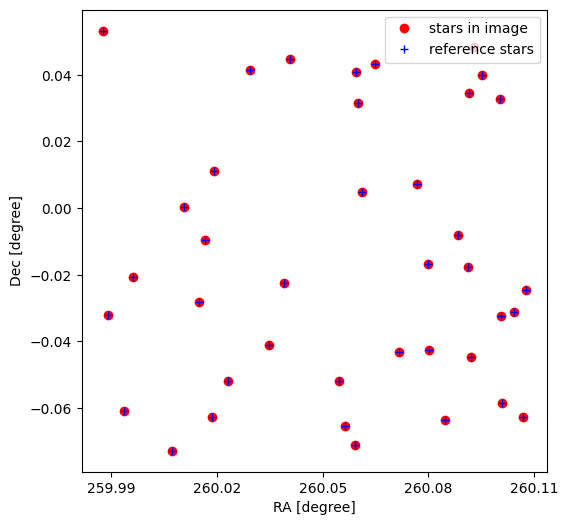

In [86]:
fig, axes = plt.subplots(1, 1, figsize= (6, 6))
from matplotlib.ticker import MaxNLocator
# axes[0].plot(match_radec[0], match_radec[1], '.', c='red')
# axes[1].plot(match_res_ra_gaia_uniqe, match_res_dec_gaia_uniqe, '.', c='blue')

axes.plot(match_radec[0], match_radec[1], 'o', c='red', label="stars in image")
axes.plot(match_res_ra_gaia_uniqe, match_res_dec_gaia_uniqe, '+', c='blue', label="reference stars")
axes.set_ylabel("Dec [degree]")
axes.set_xlabel("RA [degree]")
axes.xaxis.set_major_locator(MaxNLocator(5))
axes.legend(loc=1)

### 更新底片模型

In [58]:
# 全体星应用
sext_flags = sext_out_filter[:]["FLAGS"]
sext_out_x = sext_out_filter[:]["X_IMAGE"][sext_flags == 0]
sext_out_y = sext_out_filter[:]["Y_IMAGE"][sext_flags == 0]
# sext_out_x = sext_out_filter[:]["X_IMAGE"]
# sext_out_y = sext_out_filter[:]["Y_IMAGE"]
# sext_out_mag_bp = sext_out_filter[:][f"mag_{band}"]
sext_out_mag_auto = sext_out_filter[:]["MAG_AUTO"][sext_flags == 0]

# sext_out_x = df["XWIN_IMAGE"]
# sext_out_y = df["YWIN_IMAGE"]
# sext_out_mag = df["Gmag(mag)"]

sext_out_xieta = use_plate_model(sext_out_x - x_ref, sext_out_y - y_ref, A_CD, cof)
sext_out_radec = ideal_cel_coord(sext_out_xieta[0], sext_out_xieta[1], pointing_ra, pointing_dec)

sext_out_ra = sext_out_radec[0]
sext_out_dec = sext_out_radec[1]

# 全体再次匹配
refcat_lib_all = pd.DataFrame({"RA_ICRS": refcat_ra_now, "DE_ICRS": refcat_dec_now, "magg": ref_filter["magg"], "magr": ref_filter["magr"], "magi": ref_filter["magi"], "pos_x": ref_filter["Pos_X"], "pos_y": ref_filter["Pos_Y"]})
side_threshold = 0.00001
match_res_all = []

for i in range(len(sext_out_ra)):
    temp_lib = np.array([sext_out_ra[i], sext_out_dec[i]])
    index = np.sum(np.abs(refcat_lib_all.iloc[:, 0:2] - temp_lib) < side_threshold, axis=1) == 2
    if np.sum(index) == 1:
        match_res_all.append(np.hstack((np.array(temp_lib), int(i), refcat_lib_all.iloc[np.where(index == True)[0][0]])))

match_res_all = np.array(match_res_all)

# 更新底片模型及
match_res_xi_gaia_all, match_res_eta_gaia_all = cel_ideal_coord(match_res_all[:, 3], match_res_all[:, 4], pointing_ra, pointing_dec)
Y_xi = match_res_xi_gaia_all
Y_eta = match_res_eta_gaia_all

match_res_x_sext_all = np.zeros_like(match_res_xi_gaia_all)
match_res_y_sext_all = np.zeros_like(match_res_xi_gaia_all)
# match_res_mag_bp_all = np.zeros_like(match_res_xi_gaia_all)
match_res_mag_auto_all = np.zeros_like(match_res_xi_gaia_all)
for index, i in enumerate(match_res_all[:, 2]):
    match_res_x_sext_all[index] = sext_out_x[int(i)]
    match_res_y_sext_all[index] = sext_out_y[int(i)]
    # match_res_mag_bp_all[index] = sext_out_mag_bp[int(i)]
    match_res_mag_auto_all[index] = sext_out_mag_auto[int(i)]

match_x = match_res_x_sext_all
match_y = match_res_y_sext_all
match_mag = match_res_all[:, 6]
match_mag_auto = match_res_mag_auto_all

# mag_th = 20
# mag_filter = match_mag_i > mag_th
# match_x = match_x[mag_filter]
# match_y = match_y[mag_filter]
# match_mag_i = match_mag_i[mag_filter]
# Y_xi = Y_xi[mag_filter]
# Y_eta = Y_eta[mag_filter]


print("the matched stars", len(match_x))

# cof = int(np.floor((np.sqrt(8 * len(match_x) + 1) - 3) / 2))
cof = 1
cof_mag = 4
# A_CD = cal_plate_model(match_x - x_ref, match_y - y_ref, Y_xi, Y_eta, cof)
A_CD = cal_plate_model_mag(match_x - x_ref, match_y - y_ref, match_mag, Y_xi, Y_eta, cof, cof_mag)
print(A_CD)

# 再应用底片模型
# match_xieta = use_plate_model(match_x - x_ref, match_y - y_ref, A_CD, cof)
match_xieta = use_plate_model_mag(match_x - x_ref, match_y - y_ref, match_mag, A_CD, cof, cof_mag)
match_radec = ideal_cel_coord(match_xieta[0], match_xieta[1], pointing_ra, pointing_dec)
gaia_radec = (match_res_all[:, 3], match_res_all[:, 4])
gaia_xieta = cel_ideal_coord(gaia_radec[0], gaia_radec[1], pointing_ra, pointing_dec)


# 残差
dis_xi = (match_xieta[0] - gaia_xieta[0])
dis_eta = (match_xieta[1] - gaia_xieta[1])
dis_ra = (match_radec[0] - match_res_all[:, 3]) * 3600000
dis_dec = (match_radec[1] - match_res_all[:, 4]) * 3600000

print(np.std(dis_ra), np.std(dis_dec), cof)

the matched stars 2536
[[ 3.18976861e-05 -2.42407676e-07  2.18667807e-12 -5.00457838e-06
   2.94440526e-07 -7.62977897e-09  7.33530790e-11]
 [ 4.19773717e-05  8.03270623e-14  2.42408774e-07 -7.01148573e-06
   4.34370776e-07 -1.19009956e-08  1.21738837e-10]]
5.498259864768735 5.094984079708398 1


In [39]:
# match_res_pickle = pd.DataFrame({"X_IMAGE": match_x, "Y_IMAGE": match_y, "DIS_RA": dis_ra, "DIS_DEC": dis_dec, "MAG_BP": match_mag_bp, "MAG_AUTO": match_mag_auto})

# with open(f'match_res/match_{band}_{unkonw_index}_res.pkl', 'wb') as f:
#     pickle.dump(match_res_pickle, f)

### 残差图

In [49]:
# create bins
bins_num = 1
bins_x = np.linspace(0.5, 9216.5, bins_num + 1)
bins_y = np.linspace(0.5, 9232.5, bins_num + 1)

# bins' centers of all box
bin_centers_x = (bins_x[:-1] + bins_x[1:]) / 2
bin_centers_y = (bins_y[:-1] + bins_y[1:]) / 2
bin_centers = np.transpose([np.tile(bin_centers_x, len(bin_centers_y)), np.repeat(bin_centers_y, len(bin_centers_x))])

# calculate error
distort_sum_bins = np.zeros((bins_num, bins_num))
distort_sum_values_x = np.zeros((bins_num, bins_num))
distort_sum_values_y = np.zeros((bins_num, bins_num))

dis_res_xy = [np.vstack((match_x, match_y, dis_xi, dis_eta))]
[distort_sum_bins, distort_sum_values_x, distort_sum_values_y] = cal_distort_model(dis_res_xy, bins_x, bins_y, bins_num, distort_sum_bins, distort_sum_values_x, distort_sum_values_y)

distort_mean_values_x = np.divide(distort_sum_values_x, distort_sum_bins, out=np.zeros_like(distort_sum_values_x), where=distort_sum_bins != 0)
distort_mean_values_y = np.divide(distort_sum_values_y, distort_sum_bins, out=np.zeros_like(distort_sum_values_y), where=distort_sum_bins != 0)

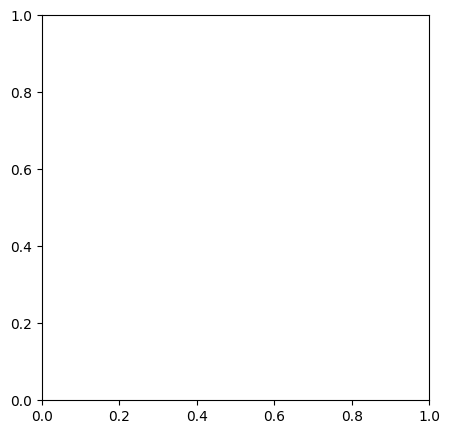

In [50]:
# mag-distortion
bins_x_id, bins_y_id = match_box_id(match_x, match_y, bins_x, bins_y)

dict_mag_dis = {}
fig, axes = plt.subplots(bins_num, bins_num, figsize= (bins_num * 5, bins_num * 5))

# for i in range(0, bins_num):
#     for j in range(0, bins_num):

#         # 各个区域画图
#         dict_mag_dis.update({str(i)+str(j): []})
#         index = (bins_x_id == i) & (bins_y_id == j)
#         match_mag_box = match_mag_bp[index]
#         match_x_box = match_x[index]
#         match_y_box = match_y[index]
#         dis_ra_box = dis_ra[index]
#         dis_dec_box = dis_dec[index]
#         dis_ra_box, match_mag_ra_box = sigma_filter(dis_ra_box, match_mag_box, 3)
#         dis_dec_box, match_mag_dec_box = sigma_filter(dis_dec_box, match_mag_box, 3)
#         axes[i][j].plot(match_mag_ra_box, dis_ra_box, '.', c='blue', label="ra")
#         axes[i][j].plot(match_mag_dec_box, dis_dec_box, '.', c='red', label="dec")
#         axes[i][j].set_xlabel("mag")
#         axes[i][j].set_ylabel(r"$\Delta$ ra or $\Delta$ dec")
#         axes[i][j].legend()

        # 
        # bins_num_mag_box = 8
        # bins_mag_box = np.linspace(np.min(match_mag_box) * 0.99, max(match_mag_box) * 1.01, bins_num_mag_box + 1)
        # bin_centers_mag_box = (bins_mag_box[:-1] + bins_mag_box[1:]) / 2
        # dict_mag_dis[str(i)+str(j)].append(bin_centers_mag_box)

        # bins_mag_box_dis = []
        # bins_mag_box_id = np.digitize(match_mag_box, bins_mag_box) - 1
        # for k in range(0, bins_num_mag_box):
        #     index_mag = bins_mag_box_id == k
        #     bins_mag_box_dis.append(np.std(dis_box[index_mag]))
        # dict_mag_dis[str(i)+str(j)].append(bins_mag_box_dis)
            


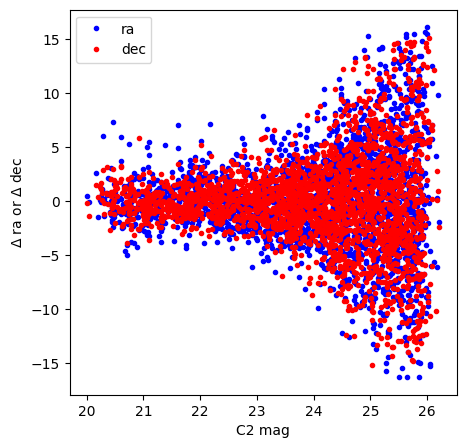

In [51]:
fig, axes = plt.subplots(bins_num, bins_num, figsize= (bins_num * 5, bins_num * 5))

for i in range(0, bins_num):
    for j in range(0, bins_num):

        # 各个区域画图
        dict_mag_dis.update({str(i)+str(j): []})
        index = (bins_x_id == i) & (bins_y_id == j)
        match_mag_box = match_mag[index]
        match_x_box = match_x[index]
        match_y_box = match_y[index]
        dis_ra_box = dis_ra[index]
        dis_dec_box = dis_dec[index]
        # dis_ra_box, match_mag_ra_box = sigma_filter(dis_ra_box, match_mag_box, 3)
        # dis_dec_box, match_mag_dec_box = sigma_filter(dis_dec_box, match_mag_box, 3)

        # index_ra = (match_mag_ra_box < -5) & (match_mag_ra_box > -14)
        # index_dec = (match_mag_dec_box < -5) & (match_mag_dec_box > -14)

        dis_ra_box, dis_dec_box, match_mag_radec_box, filter = sigma_filter_2(dis_ra_box, dis_dec_box, match_mag_box, 3)
        index_ra_dec = (match_mag_radec_box < 29) & (match_mag_radec_box > 20)

        axe = axes if bins_num == 1 else axes[i][j]
        axe.plot(match_mag_radec_box[index_ra_dec], dis_ra_box[index_ra_dec], '.', c='blue', label="ra")
        axe.plot(match_mag_radec_box[index_ra_dec], dis_dec_box[index_ra_dec], '.', c='red', label="dec")
        axe.set_xlabel(f"{band} mag")
        axe.set_ylabel(r"$\Delta$ ra or $\Delta$ dec")
        axe.legend()

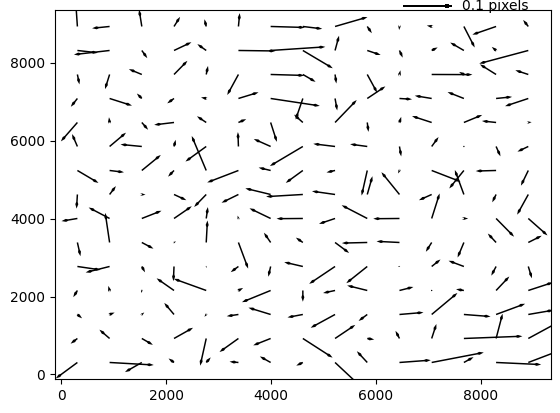

In [43]:
bins_num = 15
bins_x = np.linspace(0.5, 9216.5, bins_num + 1)
bins_y = np.linspace(0.5, 9232.5, bins_num + 1)

# bins' centers of all box
bin_centers_x = (bins_x[:-1] + bins_x[1:]) / 2
bin_centers_y = (bins_y[:-1] + bins_y[1:]) / 2
bin_centers = np.transpose([np.tile(bin_centers_x, len(bin_centers_y)), np.repeat(bin_centers_y, len(bin_centers_x))])

# calculate error
distort_sum_bins = np.zeros((bins_num, bins_num))
distort_sum_values_x = np.zeros((bins_num, bins_num))
distort_sum_values_y = np.zeros((bins_num, bins_num))

# dis_res_xy = [np.vstack((match_x, match_y, dis_ra, dis_dec))]
dis_res_xy = [np.vstack((match_x[filter][index_ra_dec], match_y[filter][index_ra_dec], dis_ra[filter][index_ra_dec], dis_dec[filter][index_ra_dec]))]
[distort_sum_bins, distort_sum_values_x, distort_sum_values_y] = cal_distort_model(dis_res_xy, bins_x, bins_y, bins_num, distort_sum_bins, distort_sum_values_x, distort_sum_values_y)

distort_mean_values_x = np.divide(distort_sum_values_x, distort_sum_bins, out=np.zeros_like(distort_sum_values_x), where=distort_sum_bins != 0)
distort_mean_values_y = np.divide(distort_sum_values_y, distort_sum_bins, out=np.zeros_like(distort_sum_values_y), where=distort_sum_bins != 0)

fig, axes = plt.subplots(1, 1)
quiver_scale = 9216
quiver_show_scale = 0.1
quiver = axes.quiver(bin_centers[:, 0], bin_centers[:, 1], distort_mean_values_x.flatten() / 50, distort_mean_values_y.flatten() / 50, scale=1 / quiver_scale, angles = 'xy', scale_units="xy", headwidth=2, headlength=3, width=0.003)
axes.quiverkey(quiver, 0.8, 1.01, quiver_show_scale, f"{quiver_show_scale} pixels",labelpos='E', coordinates='axes')

In [44]:
# fig, axes = plt.subplots(bins_num, bins_num, figsize= (bins_num * 4, bins_num * 4))

# for i in range(0, bins_num):
#     for j in range(0, bins_num):
#         axes[i][j].plot(dict_mag_dis[str(i)+str(j)][0], dict_mag_dis[str(i)+str(j)][1], '.')
#         axes[i][j].set_xlabel("mag")
#         axes[i][j].set_ylabel(r"$\sigma$ dec")


In [45]:
# dict_mag_dis["21"]

# x = dict_mag_dis["21"][0]
# y = dict_mag_dis["21"][1]

# X = np.array([np.ones_like(x), x]).T
# Y = y
# A = np.linalg.inv(X.T @ X) @ X.T @ Y

# plt.plot(dict_mag_dis["21"][0], dict_mag_dis["21"][1], '.')
# plt.plot(dict_mag_dis["21"][0], dict_mag_dis["21"][0] * A[1] + A[0], '.')

### test

In [46]:
# # create bins
# bins_num = 4
# bins_x = np.linspace(0.5, 9216.5, bins_num + 1)
# bins_y = np.linspace(0.5, 9232.5, bins_num + 1)

# # bins' centers of all box
# bin_centers_x = (bins_x[:-1] + bins_x[1:]) / 2
# bin_centers_y = (bins_y[:-1] + bins_y[1:]) / 2
# bin_centers = np.transpose([np.tile(bin_centers_x, len(bin_centers_y)), np.repeat(bin_centers_y, len(bin_centers_x))])

# # calculate distortion error model
# distort_sum_bins = np.zeros((bins_num, bins_num))
# distort_sum_values_x = np.zeros((bins_num, bins_num))
# distort_sum_values_y = np.zeros((bins_num, bins_num))

# dis_res_xy = [np.vstack((match_x, match_y, dis_ra, dis_dec))]
# [distort_sum_bins, distort_sum_values_x, distort_sum_values_y] = cal_distort_model(dis_res_xy, bins_x, bins_y, bins_num, distort_sum_bins, distort_sum_values_x, distort_sum_values_y)

# distort_mean_values_x = np.divide(distort_sum_values_x, distort_sum_bins, out=np.zeros_like(distort_sum_values_x), where=distort_sum_bins != 0)
# distort_mean_values_y = np.divide(distort_sum_values_y, distort_sum_bins, out=np.zeros_like(distort_sum_values_y), where=distort_sum_bins != 0)

# # mag-distortion
# bins_x_id, bins_y_id = match_box_id(match_x, match_y, bins_x, bins_y)

# fig, axes = plt.subplots(bins_num, bins_num, figsize= (bins_num * 4, bins_num * 4))

# for i in range(0, bins_num):
#     for j in range(0, bins_num):
#         index = (bins_x_id == i) & (bins_y_id == j)
#         axes[i][j].plot(match_mag[index] * match_x[index], dis_dec[index], '.')

# ax = plt.matshow(distort_sum_bins)
# plt.colorbar(ax.colorbar, fraction=0.025)

In [47]:
# fig, axes = plt.subplots(1, 2)
# axes[0].quiver(bin_centers[:, 0], bin_centers[:, 1], distort_mean_values_x.flatten(), distort_mean_values_y.flatten(), scale=1500)

# axes[1].matshow(distort_mean_values_x)

# ax = plt.matshow(distort_mean_values_x)
# plt.colorbar(ax.colorbar, fraction=0.025)
# plt.title("matrix X");
# plt.show()

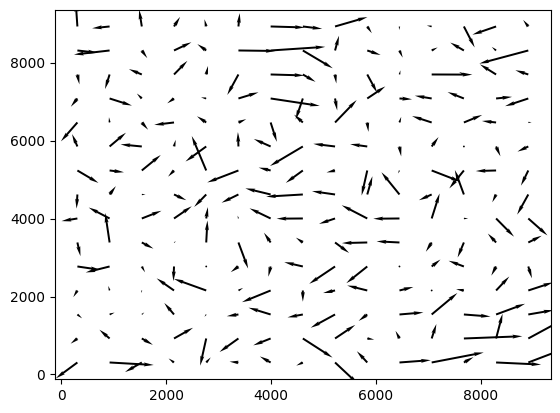

In [48]:
fig, axes = plt.subplots(1, 1)
axes.quiver(bin_centers[:, 0], bin_centers[:, 1], distort_mean_values_x.flatten(), distort_mean_values_y.flatten(), headwidth=2, width=0.004, angles = 'xy', scale_units="xy")